In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
insurance_data = pd.read_csv('insurance.csv')

In [3]:
insurance_data.shape

(1338, 7)

In [4]:
insurance_data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [5]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
insurance_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### Check for duplicate rows

In [8]:
duplicates = insurance_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    insurance_data = insurance_data.drop_duplicates()
    print("Duplicates removed.")


Number of duplicate rows: 1
Duplicates removed.


In [9]:
missing_values = insurance_data.isnull().sum()
print("\nMissing values in each column:\n", missing_values)


Missing values in each column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [10]:
insurance_data['sex'] = insurance_data['sex'].astype('category')


In [11]:
insurance_data['smoker'] = insurance_data['smoker'].astype('category')


In [12]:
insurance_data['region'] = insurance_data['region'].astype('category')

In [13]:
# Use NumPy to add a new feature: Log-transformed charges
insurance_data['log_charges'] = np.log1p(insurance_data['charges'])

## Visualize and clean

In [14]:
def remove_outliers(df, column):
    Q1 = np.percentile(df[column], 25)  # First quartile (25th percentile)
    Q3 = np.percentile(df[column], 75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"\nOutlier bounds for {column}: Lower = {lower_bound}, Upper = {upper_bound}")
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

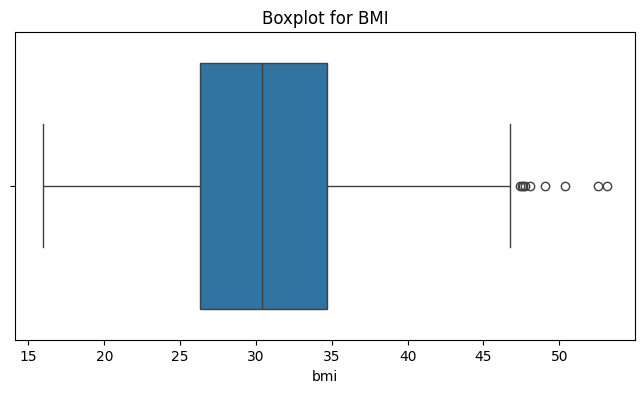


Outlier bounds for bmi: Lower = 13.674999999999994, Upper = 47.31500000000001
Shape after removing BMI outliers: (1328, 8)


In [15]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=insurance_data, x='bmi')
plt.title('Boxplot for BMI')
plt.show()
insurance_data = remove_outliers(insurance_data, 'bmi')
print(f"Shape after removing BMI outliers: {insurance_data.shape}")

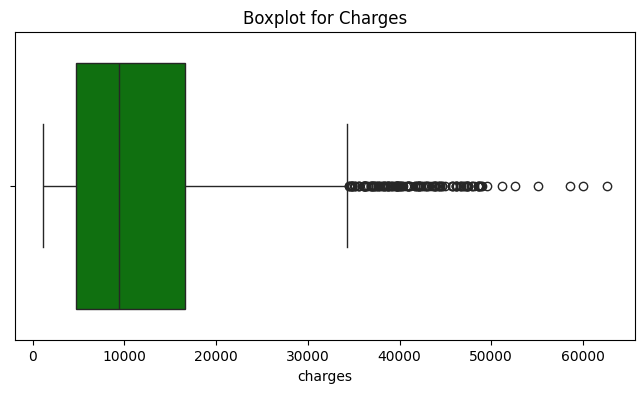


Outlier bounds for charges: Lower = -13045.6413425, Upper = 34394.269037499995
Shape after removing Charges outliers: (1190, 8)


In [16]:
plt.figure(figsize=(8,4))
sns.boxplot(data=insurance_data, x='charges', color='green')
plt.title('Boxplot for Charges')
plt.show()
insurance_data = remove_outliers(insurance_data, 'charges')
print(f"Shape after removing Charges outliers: {insurance_data.shape}")

## EDA
#### After cleaning

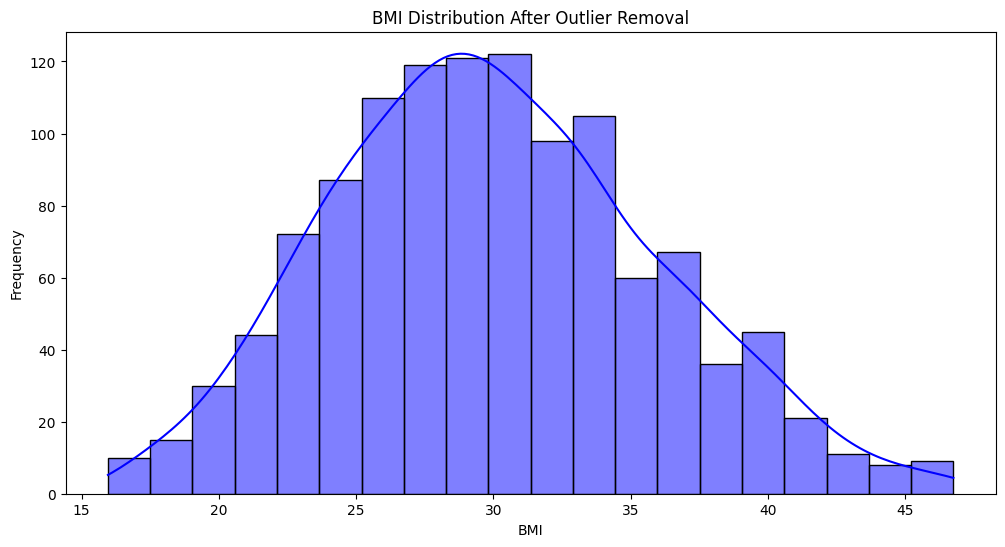

In [17]:
plt.figure(figsize=(12,6))
sns.histplot(insurance_data['bmi'], kde=True, bins=20, color='blue')
plt.title('BMI Distribution After Outlier Removal')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

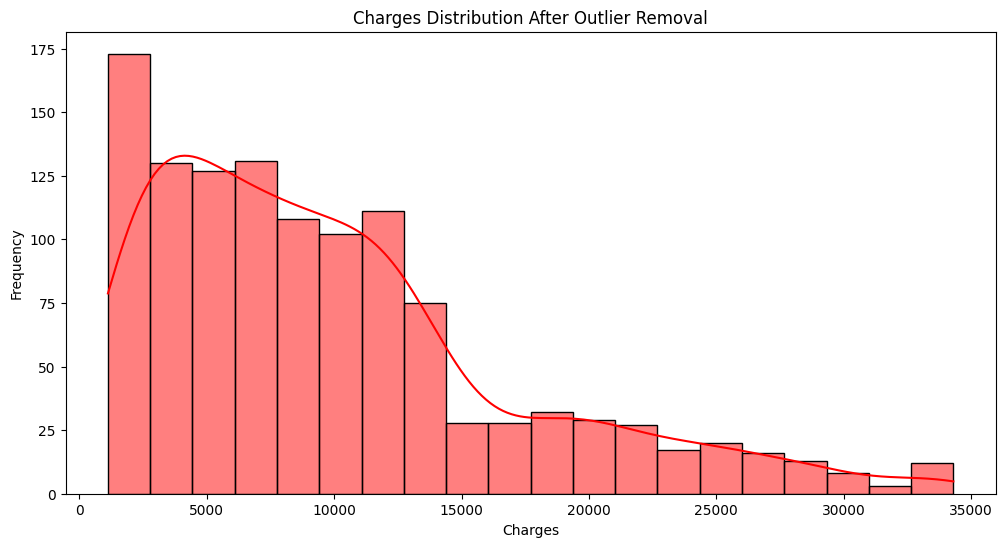

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(insurance_data['charges'], kde=True, bins=20, color='red')
plt.title('Charges Distribution After Outlier Removal')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

In [19]:
insurance_data['sex'].value_counts()

sex
female    610
male      580
Name: count, dtype: int64

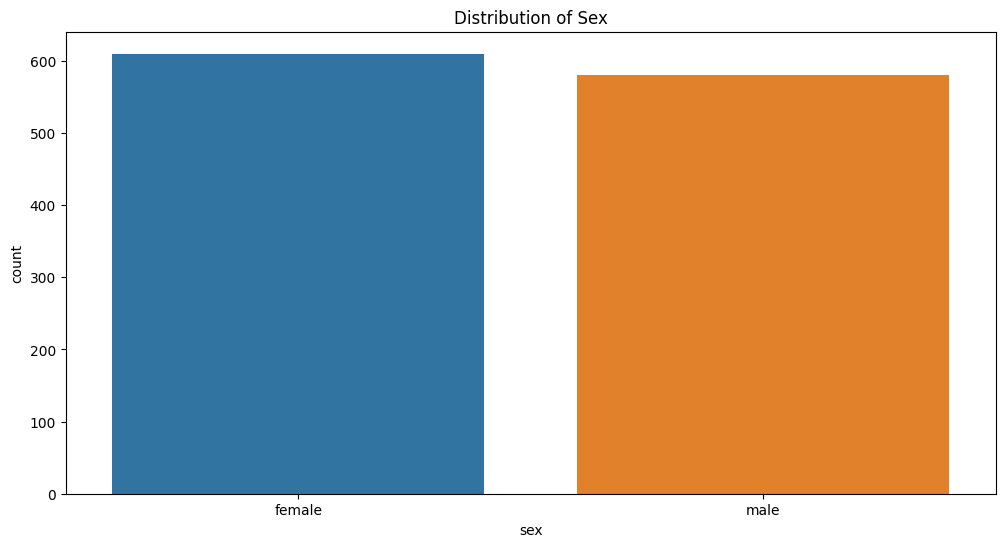

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(data=insurance_data, x='sex',hue='sex')
plt.title('Distribution of Sex')
plt.show()

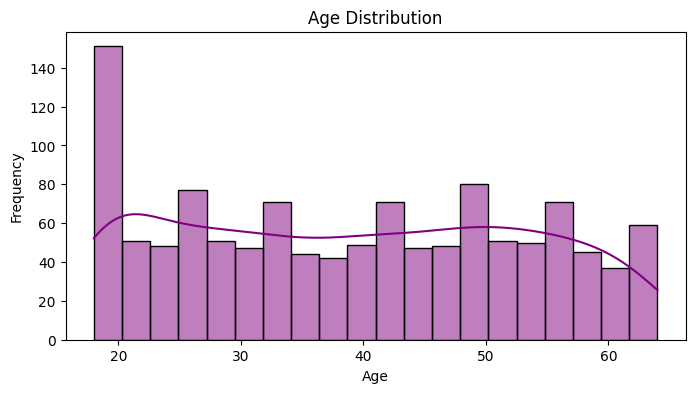

In [21]:
plt.figure(figsize=(8,4))
sns.histplot(insurance_data['age'], kde=True, bins=20, color='purple')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

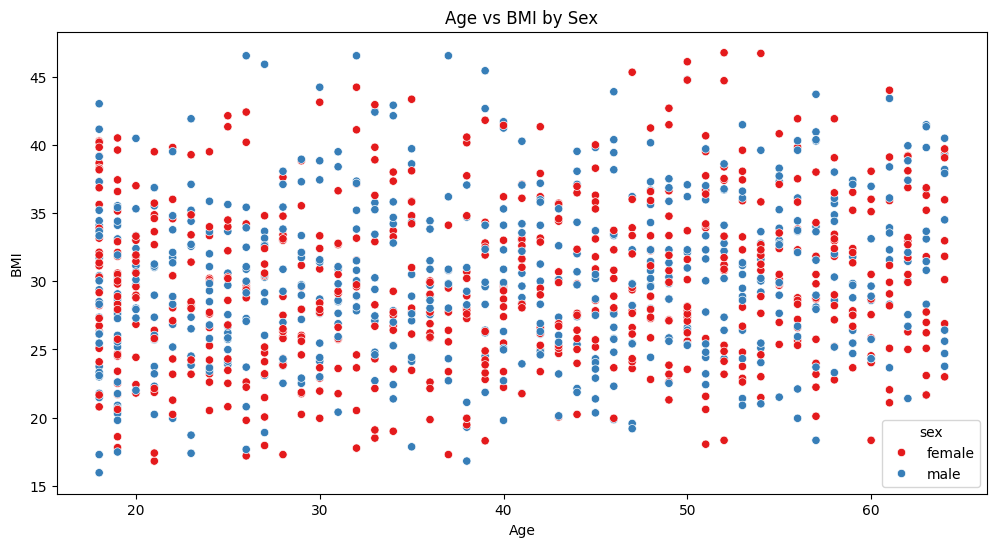

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=insurance_data, x='age', y='bmi', hue='sex', palette='Set1')
plt.title('Age vs BMI by Sex')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

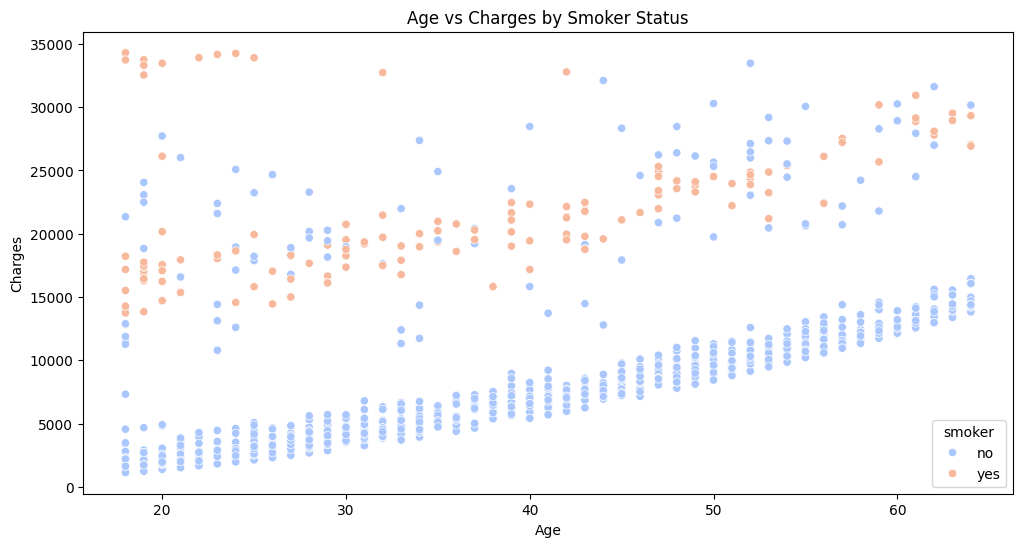

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=insurance_data, x='age', y='charges', hue='smoker', palette='coolwarm')
plt.title('Age vs Charges by Smoker Status')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

The scatter plot shows the relationship between age and charges, with points colored based on smoker status. It helps visualize how charges vary by age for smokers and non-smokers.

### Correlation heatmap

In [24]:
numeric_data = insurance_data.select_dtypes(include=[float, int])

In [25]:
corr_matrix = numeric_data.corr()

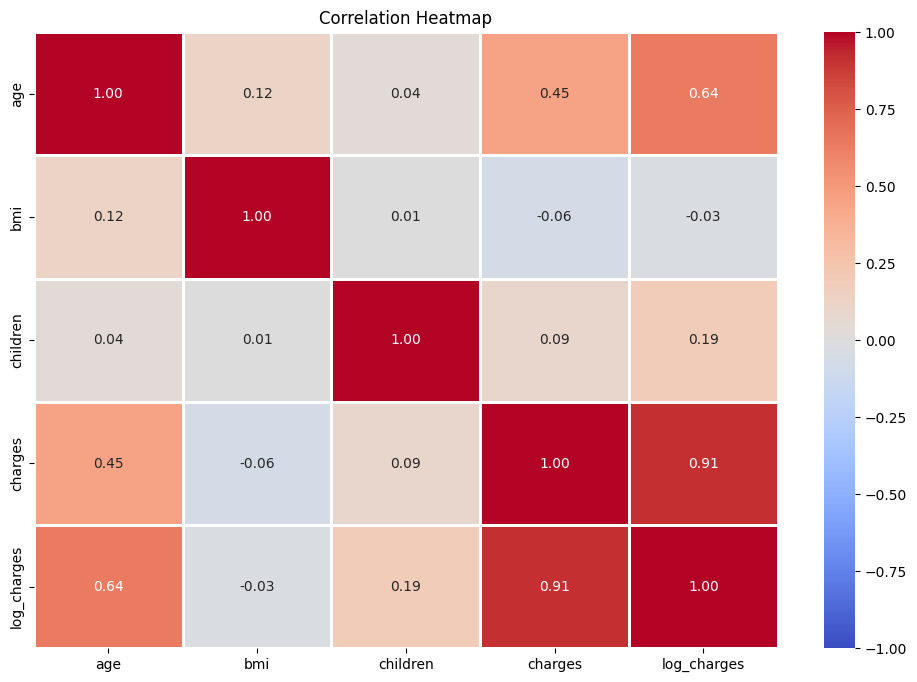

In [26]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Data preprocessing 
#### Convert categorical variables to dummy/indicator variables

In [27]:
insurance_data_encoded = pd.get_dummies(insurance_data, drop_first=True)

### Define features

In [28]:
X = insurance_data_encoded.drop('charges', axis=1)
y = insurance_data_encoded['charges']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression model

In [30]:
linear_model = LinearRegression()

In [31]:
linear_model.fit(X_train, y_train)

LinearRegression()

#### Predict on test set

In [32]:
y_pred_linear = linear_model.predict(X_test)

##### Evaluate the model

In [33]:
mse_linear = mean_squared_error(y_test, y_pred_linear)

In [34]:
print(f"\nLinear Regression - Mean Squared Error: {mse_linear:.2f}")


Linear Regression - Mean Squared Error: 6598288.84


In [35]:
r2_linear = r2_score(y_test, y_pred_linear)

In [36]:
print(f"Linear Regression - R-squared: {r2_linear:.2f}")

Linear Regression - R-squared: 0.86


## Random Forest Regressor model

In [37]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

In [38]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Predict on test

In [39]:
y_pred_rf = rf_model.predict(X_test)

##### Evaluate the model

In [40]:
mse_rf = mean_squared_error(y_test, y_pred_linear)

In [41]:
print(f"\nRandom Forest Regressor - Mean Squared Error: {mse_rf:.2f}")


Random Forest Regressor - Mean Squared Error: 6598288.84


In [42]:
r2_rf = r2_score(y_test, y_pred_rf)

In [43]:
print(f"Random Forest Regressor - R-squared: {r2_rf:.2f}")

Random Forest Regressor - R-squared: 1.00


## Visualize actual vs predicted charges  for Linear Regression

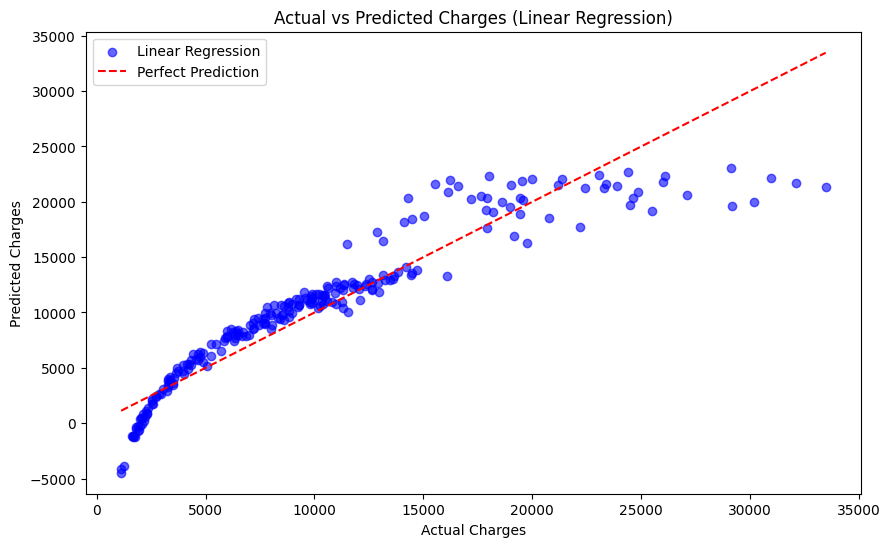

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.6, color='blue', label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Charges (Linear Regression)')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.legend()
plt.show()

## Visualize actual vs predicted charges for Random Forest

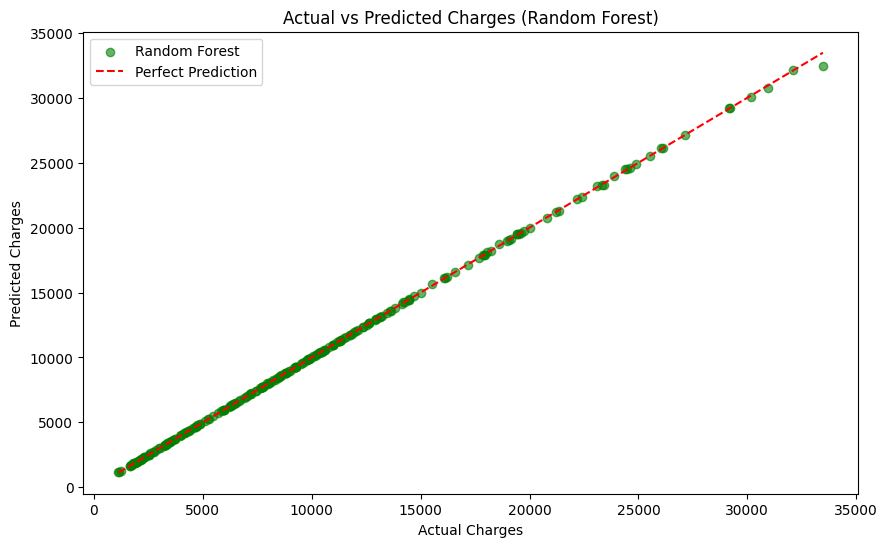

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Charges (Random Forest)')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.legend()
plt.show()

# Conclusion 

#### This project analyzed health insurance data to predict medical charges using machine learning models. Comprehensive data cleaning was performed, including handling duplicates, missing values, and outliers using the IQR method, which improved data quality. Exploratory Data Analysis (EDA) revealed significant patterns, such as higher charges for smokers and BMI’s impact on costs. Both Linear Regression and Random Forest models were implemented, with Random Forest achieving better performance (higher R-squared and lower Mean Squared Error). This demonstrates the importance of data preprocessing and robust algorithms in building accurate predictive models.